In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet, LassoCV, ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.neural_network import MLPRegressor
from utils.ml_utils import *

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

from data_prep import load_features_data
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.model_selection import TimeSeriesSplit

from sklearn.decomposition import PCA
import sqlite3 as sql



**Load the features data, these are popular trend following features used in prior literature, this notebook assumes you have the pickle file residual_returns.pkl saved in the root directory, you can download this file from the OneDrive**

In [2]:
feats = load_features_data()
feats.tail()


ret      rVol    1d_ret   1wk_ret    1m_ret  \
date       cluster                                                      
2024-03-15 15        3.398228  0.010781 -0.018600 -0.010795 -0.003738   
           16        3.080426  0.010995 -0.020717 -0.020520 -0.008363   
           17        4.019482  0.011090 -0.018740 -0.010313  0.002589   
           18       10.257413  0.011017 -0.014164 -0.005898  0.047696   
           19        3.623791  0.010924  0.001962  0.001796  0.001793   

                      1Q_ret    6M_ret   12M_ret  feature_1d_ra  \
date       cluster                                                
2024-03-15 15      -0.010729  0.088150  0.044806      -1.725280   
           16       0.004148  0.084058 -0.022932      -1.884206   
           17      -0.059504 -0.079410 -0.113126      -1.689814   
           18       0.064581  0.131315  0.153882      -1.285637   
           19       0.111935  0.238240  0.080132       0.179593   

                    feature_1wk_ra  ...  lag5_feature_MACD_short  \
date       cluster                  ...                            
2024-03-15 15            -0.447788  ...                 0.138748   
           16            -0.834625  ...                 0.097605   
           17            -0.415871  ...                 0.101396   
           18            -0.239423  ...                 0.483758   
           19             0.073513  ...                 0.173823   

                    lag5_feature_MACD_medium  lag5_feature_MACD_long  \
date       cluster                                                     
2024-03-15 15                       0.259889                0.574767   
           16                       0.322557                0.642906   
           17                       0.006033               -0.415118   
           18                       0.557877                0.717302   
           19                       0.503369                0.849991   

                    lag5_feature_skew6m  lag5_feature_skew12m  \
date       cluster                                              
2024-03-15 15                 -0.202834             -0.023611   
           16                 -0.195628             -0.024484   
           17                 -0.213701             -0.034735   
           18                 -0.229808             -0.042143   
           19                 -0.236460             -0.033288   

                    lag5_feature_kurt6m  lag5_feature_kurt12m  fwd_ret1d  \
date       cluster                                                         
2024-03-15 15                  0.229975              0.324046        NaN   
           16                  0.209541              0.330980        NaN   
           17                  0.168224              0.327998        NaN   
           18                  0.153079              0.316662        NaN   
           19                  0.163940              0.359519        NaN   

                    target  targetBin  
date       cluster                     
2024-03-15 15          NaN        NaN  
           16          NaN        NaN  
           17          NaN        NaN  
           18          NaN        NaN  
           19          NaN        NaN  

[5 rows x 89 columns]

count    125019.000000
mean          0.029297
std           1.228097
min         -18.536928
25%          -0.597784
50%           0.062029
75%           0.686203
max          70.166324
Name: target, dtype: float64
count    125019.000000
mean          0.028428
std           1.201198
min         -10.000000
25%          -0.597784
50%           0.062029
75%           0.686203
max          10.000000
Name: target, dtype: float64


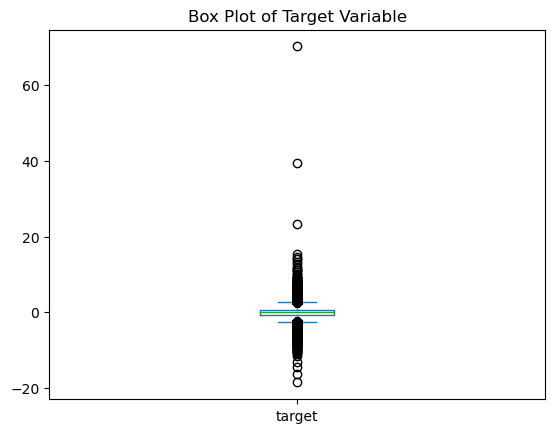

In [3]:
# distribution of tragets
feats['target'].plot(kind='box', title="Box Plot of Target Variable")
print(feats['target'].describe())

# clip the three large outliers
feats['target'] = feats['target'].clip(-10., 10.)
print(feats['target'].describe())

<Axes: >

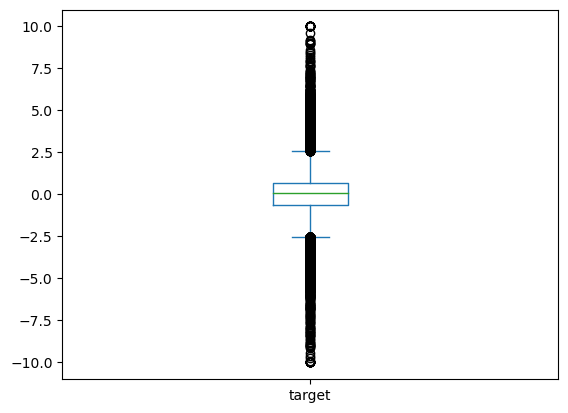

In [4]:
feats['target'].plot(kind='box')

**Extract the predictive features and target, which is one day forward risk adjusted return - drop na on this subset**

In [5]:
features = [f for f in feats.columns if f.startswith("feature")]
target = ["target"]
lag_feats = [f for f in feats.columns if f.startswith('lag')]

# make a new feature vector for features + lags

all_feats = features + lag_feats + target
feats.dropna(subset=all_feats, inplace=True)
feats = feats[all_feats]

print("Shape of features", feats.shape)



Shape of features (119900, 79)


**Break out X and y and set up cross-validation, define models**

In [6]:
X = feats[all_feats].copy()

# set some configs
N_ITER=25

# Random Forest Regressor
baseRF = RandomForestRegressor(max_depth=5, 
                               n_estimators=1000,
                               max_features=int(1),
                               random_state=49, 
                               n_jobs=-1)

# simple-grid
grid = {'rf__n_estimators': np.arange(100, 2000, 100),
        'rf__max_depth': [3, 6, 9, 12],
        'rf__max_features': [int(1), 'sqrt'],
        'rf__min_weight_fraction_leaf': np.arange(0.0, 0.05, 0.005)}
paramsRF = ParameterSampler(n_iter=N_ITER, param_distributions=grid)


rfPipe = Pipeline(steps=[('scaler', RobustScaler()), ('rf',baseRF)])
rfPipeFS = Pipeline(steps=[('scaler', RobustScaler()),
                           ('selector', SelectFromModel(baseRF, threshold='mean')),
                           ('rf',baseRF)])

# Elastic Net Regressor
net = ElasticNet(max_iter=1000)
eNetPipe = Pipeline(steps=[('scaler', RobustScaler()), ('net', net)])
eNetPipePCA = Pipeline(steps=[('scaler', RobustScaler()),
                              ('pca', PCA(n_components=.95)),
                              ('net', net)])

eNet_grid = {'net__alpha': [1e-5, 1e-4, 1e-3, 1e-2],
             'net__l1_ratio': np.arange(0.10, .90, 0.01)}

paramsNet = ParameterSampler(n_iter=N_ITER, param_distributions=eNet_grid)

# MLP Regressor
mlp = MLPRegressor(hidden_layer_sizes=(16, 8),
                   random_state=49,
                   shuffle=False,
                   max_iter=500,
                   early_stopping=True,
                   learning_rate='constant')

mlp_pipe = Pipeline(steps=[('scaler', RobustScaler()), ('mlp', mlp)])
mlp_pipeFS = Pipeline(steps=[('scaler', RobustScaler()),
                             ('selector', SelectFromModel(baseRF, threshold='mean')),
                             ('mlp', mlp)])
mlp_grid = {'mlp__learning_rate_init': [.000001, .00001, .0001, .001],
            'mlp__batch_size': [32, 64, 128, 256],
            'mlp__hidden_layer_sizes': [(12, 6), (16, 8), (6, 3), (4, 2), (32, 16)],
            'mlp__alpha': [.000001, .00001, .0001, .001, .01]}
mlp_sampler = ParameterSampler(n_iter=N_ITER, param_distributions=mlp_grid)


# make the hidden layer sizes a little bit smaller here
mlp_grid2 = {'mlp__learning_rate_init': [.000001, .00001, .0001, .001],
            'mlp__batch_size': [32, 64, 128, 256],
            'mlp__hidden_layer_sizes': [(6, 3), (4, 2), (8, 4)],
            'mlp__alpha': [.000001, .00001, .0001, .001, .01]}
mlp_sampler2 = ParameterSampler(n_iter=N_ITER, param_distributions=mlp_grid2)

# append the models
models = [(mlp_pipe, mlp_sampler, 'preds_MLP'),
          (mlp_pipeFS, mlp_sampler2, 'preds_MLP_FS'),
          (eNetPipe, paramsNet, 'preds_eNet'),
          (eNetPipePCA, paramsNet, 'preds_eNetPCA'),
          (rfPipe, paramsRF, 'preds_RF'),
          (rfPipeFS, paramsRF, 'preds_RF_FS')]


**Form the training loop, here we train on 3 year expanding windows, using 90% of each split for training and 10% for tuning hyper-parameters, we then use the same model to forecast forward 3-years before re-training again.**

In [7]:
def train_single_model(model, sampler, model_name):
    predictions = []
    scores = []
    for train, test in tqdm(get_cv_splits(X, split_length=252*5)):
        # break out X and y train, test
        X_train, y_train = train[features], train[target] 
        X_test, y_test = test[features], test[target]

        # hyper-param loop
        X_train2, X_val, y_train2, y_val = train_val_split(X_train, y_train)
        print(X_train2.shape, X_val.shape)

        # inner loop for parameter tuning
        gscv_scores = {'scores': [], 'grid':[]}
        for k, p in enumerate(sampler):
            model.set_params(**p)
            try:
                model.n_jobs=-1
            except Exception as e:
                pass
            model.fit(X_train2, y_train2.values.reshape(y_train2.shape[0], ))
            _pred = model.predict(X_val)
            _score = mean_squared_error(y_val, _pred)
            gscv_scores['scores'].append(_score)
            gscv_scores['grid'].append(p)
            print(f'Iter: {k}: Score: {_score}')

        # now fit the best model
        best_model = pd.DataFrame(gscv_scores).sort_values(by='scores').head(1)['grid'].values[0]
        print(pd.DataFrame(gscv_scores).sort_values(by='scores').head(1))
        print(f'Best Model: {best_model}')
        best_model = model.set_params(**best_model)
        best_model.n_jobs=-1
        best_model.fit(X_train, y_train.values.reshape(y_train.shape[0], ))
        preds = best_model.predict(X_test)

        # append the predictions
        predictions.append(pd.Series(index=y_test.index, data=preds))
       
        # score
        scores.append(mean_squared_error(y_test, preds))

    # predictions
    predictions = pd.concat(predictions).to_frame(model_name)
    return predictions

# train all models selected
predictions = []
for model in models:
    out = train_single_model(model[0], model[1], model[2])
    predictions.append(out)

# concat the predictions by columns
predictions = pd.concat(predictions, axis=1)

0it [00:00, ?it/s]

4
(22698, 13) (2520, 13)
Iter: 0: Score: 1.5083058777207863
Iter: 1: Score: 1.5507931928574767


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 2: Score: 2.004211117481786
Iter: 3: Score: 1.5185517482923292
Iter: 4: Score: 1.5532864821568984
Iter: 5: Score: 1.5844046984493254
Iter: 6: Score: 1.5334471575142818
Iter: 7: Score: 1.5039578189989895
Iter: 8: Score: 1.5742976044569998


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 9: Score: 1.7983799442890058
Iter: 10: Score: 1.6565985250314548
Iter: 11: Score: 1.5065691237811965
Iter: 12: Score: 1.5714383746769396
Iter: 13: Score: 1.5206539429141803
Iter: 14: Score: 1.5410065864421603
Iter: 15: Score: 1.578813678031043
Iter: 16: Score: 1.5317173805326625
Iter: 17: Score: 1.5354328225887384
Iter: 18: Score: 1.560786305958302
Iter: 19: Score: 1.526327582432145
Iter: 20: Score: 1.5410957295942467


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 21: Score: 1.9967006931729616
Iter: 22: Score: 1.5696590218798046
Iter: 23: Score: 1.5783380619651528
Iter: 24: Score: 1.513154786621188
     scores                                               grid
7  1.503958  {'mlp__learning_rate_init': 1e-05, 'mlp__hidde...
Best Model: {'mlp__learning_rate_init': 1e-05, 'mlp__hidden_layer_sizes': (4, 2), 'mlp__batch_size': 256, 'mlp__alpha': 0.01}


1it [02:14, 134.75s/it]

(45396, 13) (5040, 13)
Iter: 0: Score: 1.8137361774531062
Iter: 1: Score: 1.7917552526779998
Iter: 2: Score: 2.6369075579712904
Iter: 3: Score: 1.8966419991057513
Iter: 4: Score: 1.5620077856514922
Iter: 5: Score: 1.4852340319068693
Iter: 6: Score: 1.4764603479874063
Iter: 7: Score: 1.6188985166914025
Iter: 8: Score: 1.569262424212489
Iter: 9: Score: 1.5592246804439425
Iter: 10: Score: 1.8225480431820735
Iter: 11: Score: 1.4466006009194752
Iter: 12: Score: 1.4744138143650527
Iter: 13: Score: 1.5264283718864629
Iter: 14: Score: 1.9085205093270974
Iter: 15: Score: 1.8666308144299555
Iter: 16: Score: 1.898816016495261
Iter: 17: Score: 1.487042693024627
Iter: 18: Score: 1.6918555340059758
Iter: 19: Score: 1.5350693295396507
Iter: 20: Score: 1.5175477434846145
Iter: 21: Score: 2.2040015890336107
Iter: 22: Score: 1.4743979882083749
Iter: 23: Score: 1.4573336479972656
Iter: 24: Score: 1.934842691460655
      scores                                               grid
11  1.446601  {'mlp__learni

2it [05:41, 176.81s/it]

(68076, 13) (7560, 13)
Iter: 0: Score: 1.388151973022939
Iter: 1: Score: 1.407404472647332
Iter: 2: Score: 1.3816962250829297


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 3: Score: 1.4478743979225333
Iter: 4: Score: 1.4008521620673757
Iter: 5: Score: 1.3896257173401003
Iter: 6: Score: 1.4059753164434172
Iter: 7: Score: 1.4009286868377375
Iter: 8: Score: 1.4042465113256628
Iter: 9: Score: 1.4055583787891217
Iter: 10: Score: 1.4083929761943152
Iter: 11: Score: 1.388691685125857
Iter: 12: Score: 1.4030971178354124
Iter: 13: Score: 1.408562965654131
Iter: 14: Score: 1.4460412615854128
Iter: 15: Score: 1.3947951746229164
Iter: 16: Score: 1.3802242927967598
Iter: 17: Score: 1.3844067758786205


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 18: Score: 1.7089349244253136
Iter: 19: Score: 1.3816616411780351
Iter: 20: Score: 1.4291922435850837
Iter: 21: Score: 1.393399426133024
Iter: 22: Score: 1.4085813266950757
Iter: 23: Score: 1.3816792766250272
Iter: 24: Score: 1.3899979319887683
      scores                                               grid
16  1.380224  {'mlp__learning_rate_init': 1e-05, 'mlp__hidde...
Best Model: {'mlp__learning_rate_init': 1e-05, 'mlp__hidden_layer_sizes': (12, 6), 'mlp__batch_size': 128, 'mlp__alpha': 0.001}


3it [10:16, 222.09s/it]

(90756, 13) (10080, 13)
Iter: 0: Score: 1.4816183160252898
Iter: 1: Score: 1.5290793285584312
Iter: 2: Score: 1.492440061078401
Iter: 3: Score: 1.5016424820750784
Iter: 4: Score: 1.5207395240425519
Iter: 5: Score: 1.483384530426679
Iter: 6: Score: 1.5154122119613433
Iter: 7: Score: 1.5124274146242724
Iter: 8: Score: 1.5056584246779874


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 9: Score: 1.6109557722145234
Iter: 10: Score: 1.5018043839789719
Iter: 11: Score: 1.4953553698533621
Iter: 12: Score: 1.4844195261319697
Iter: 13: Score: 1.5018035937046545
Iter: 14: Score: 1.531404899637237
Iter: 15: Score: 1.5071081066048855
Iter: 16: Score: 1.4818621243603862
Iter: 17: Score: 1.5042472152362125
Iter: 18: Score: 1.481850117943651
Iter: 19: Score: 1.4889494918219217


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 20: Score: 1.4998330074935808
Iter: 21: Score: 1.4954476794543532
Iter: 22: Score: 1.4944756717516428
Iter: 23: Score: 1.5025758340706248
Iter: 24: Score: 1.5263599686188853
     scores                                               grid
0  1.481618  {'mlp__learning_rate_init': 0.0001, 'mlp__hidd...
Best Model: {'mlp__learning_rate_init': 0.0001, 'mlp__hidden_layer_sizes': (4, 2), 'mlp__batch_size': 128, 'mlp__alpha': 0.01}


4it [17:31, 262.79s/it]
0it [00:00, ?it/s]

4
(22698, 13) (2520, 13)
Iter: 0: Score: 1.4816736815342308
Iter: 1: Score: 1.51495952840576
Iter: 2: Score: 1.5018974707669772
Iter: 3: Score: 1.5044967748820526
Iter: 4: Score: 1.489654051591769
Iter: 5: Score: 1.4992766409290588
Iter: 6: Score: 1.5020922823793845


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 7: Score: 1.4793324803240364
Iter: 8: Score: 1.5049621892325928
Iter: 9: Score: 1.5220669920435976
Iter: 10: Score: 1.506194887557068
Iter: 11: Score: 1.499273022834345
Iter: 12: Score: 1.4920131504977314
Iter: 13: Score: 1.5078770839757725


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 14: Score: 1.4793270271288594
Iter: 15: Score: 1.5029228615113566
Iter: 16: Score: 1.4839919483399353
Iter: 17: Score: 1.4896718658636523
Iter: 18: Score: 1.4917435624403053
Iter: 19: Score: 1.5015579510585584
Iter: 20: Score: 1.5129993522482623
Iter: 21: Score: 1.5117362444931297


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 22: Score: 1.4793269430590037
Iter: 23: Score: 1.4899631744341102


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 24: Score: 1.614121336506708
      scores                                               grid
22  1.479327  {'mlp__learning_rate_init': 1e-06, 'mlp__hidde...
Best Model: {'mlp__learning_rate_init': 1e-06, 'mlp__hidden_layer_sizes': (8, 4), 'mlp__batch_size': 32, 'mlp__alpha': 1e-06}


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
1it [04:18, 258.42s/it]

(45396, 13) (5040, 13)
Iter: 0: Score: 1.5805248818437478
Iter: 1: Score: 1.4584716139370566
Iter: 2: Score: 2.141784764732671
Iter: 3: Score: 1.510271284333921
Iter: 4: Score: 1.7815484557964596
Iter: 5: Score: 1.7809324714474628
Iter: 6: Score: 1.5491819329449505


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 7: Score: 2.5260829214627725
Iter: 8: Score: 1.4805624724839637


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 9: Score: 2.5260829579403823
Iter: 10: Score: 1.510278318884827
Iter: 11: Score: 1.4322275993690194
Iter: 12: Score: 1.432382650456815
Iter: 13: Score: 1.6247146850539926
Iter: 14: Score: 1.9087638786347234
Iter: 15: Score: 1.7175405063641367
Iter: 16: Score: 1.825342731015919
Iter: 17: Score: 1.4645254880649072
Iter: 18: Score: 1.4668684389707658


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 19: Score: 11.236196562917165
Iter: 20: Score: 1.48841894150965
Iter: 21: Score: 1.96415151863047
Iter: 22: Score: 2.1367369791395943


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 23: Score: 2.9715163493970307


c:\Users\jaman\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Iter: 24: Score: 28.89048507895501
      scores                                               grid
11  1.432228  {'mlp__learning_rate_init': 0.001, 'mlp__hidde...
Best Model: {'mlp__learning_rate_init': 0.001, 'mlp__hidden_layer_sizes': (4, 2), 'mlp__batch_size': 256, 'mlp__alpha': 1e-06}


2it [09:59, 306.75s/it]

(68076, 13) (7560, 13)
Iter: 0: Score: 1.4039156169340645
Iter: 1: Score: 1.3931066981824125
Iter: 2: Score: 1.3794905405348945
Iter: 3: Score: 1.3813078413436666
Iter: 4: Score: 1.380781411489255
Iter: 5: Score: 1.3887750184544807
Iter: 6: Score: 1.4004538762499288
Iter: 7: Score: 1.4004121485291698
Iter: 8: Score: 1.3909325779360826


**Check distribution of the targets**

<Axes: title={'center': 'distribution of predictions'}, ylabel='Frequency'>

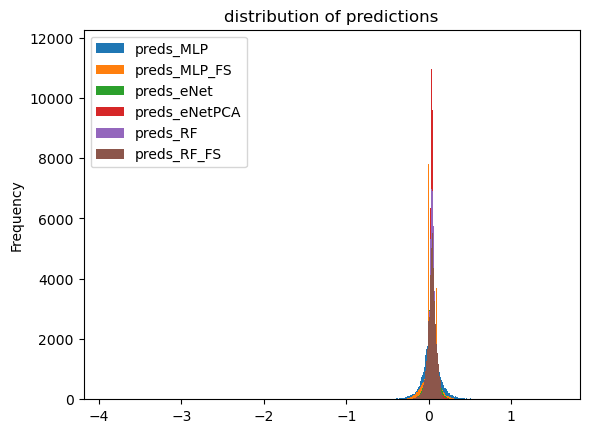

In [ ]:
# We can see predictions go negative at about the 25% percentile, market mainly goes up
predictions.plot(kind='hist', bins=1000, title="distribution of predictions")

**Join in predictions with the original dataset which has the cluster returns**

In [ ]:
# Bring in the data
data = load_features_data()

# join in predictions
predictions = predictions.merge(data, how="left", left_index=True, right_index=True)
predictions.sort_index(inplace=True)

# get the prediction columns
pred_cols = [f for f in predictions.columns if f.startswith('preds_')]

def getRetsForStrat(predictions, pred_cols):
    ret_list = []
    for pred_col in pred_cols:
        predictions[f'{pred_col}_signalQ'] = predictions.groupby(by='date')[pred_col].apply(lambda x: pd.qcut(x, 4, labels=False, duplicates='drop')).droplevel(0)
        predictions[f'{pred_col}_signalQ'] = predictions.groupby(by='cluster')[f'{pred_col}_signalQ'].shift(1)
        rets = predictions.groupby(by=['date', f'{pred_col}_signalQ'])['1d_ret'].mean().unstack()
        rets.rename(columns={col: f'{pred_col}_Q_{col}' for col in rets.columns}, inplace=True)
        ret_list.append(rets)
    return ret_list

ret_breakouts = []
# get all the returns
all_rets = getRetsForStrat(predictions, pred_cols)
for one_ret in all_rets:
    print(get_returns_breakout(one_ret))
    ret_breakouts.append(get_returns_breakout(one_ret))
    print('#################################')

# stack the returns
stacked_strat_rets = pd.concat([r.stack().to_frame('ret') for r in all_rets]) # this can hopefully be the data used for streamlit
stacked_strat_rets_cumprod = (1+stacked_strat_rets.unstack()).cumprod()

# save to sqlite3 DB
conn = sql.connect("ml_results.db")

stacked_strat_rets_cumprod.columns = stacked_strat_rets_cumprod.columns.droplevel(0)
stacked_strat_rets_cumprod.to_sql('strategy_returns', conn, if_exists='replace', index=True)
pd.concat(ret_breakouts).to_sql("metrics_df", conn, if_exists='replace', index=True)

                Annual_Return Annual_Volatility        DD       MDD    Sharpe  \
preds_MLP_Q_0.0      0.083343          0.214813   0.14496 -0.565184  0.478647   
preds_MLP_Q_1.0      0.131823           0.21136  0.148099 -0.520837   0.69621   
preds_MLP_Q_2.0      0.051629          0.210543  0.147852 -0.645283  0.349097   
preds_MLP_Q_3.0      0.109574          0.214467  0.149817 -0.486483  0.614437   

                  Sortino    Calmar ppct_postive_rets  
preds_MLP_Q_0.0  0.709296  0.147462          0.542222  
preds_MLP_Q_1.0  0.993599  0.253099          0.539471  
preds_MLP_Q_2.0  0.497119  0.080009          0.518307  
preds_MLP_Q_3.0  0.879585  0.225238           0.53037  
#################################
                   Annual_Return Annual_Volatility        DD       MDD  \
preds_MLP_FS_Q_0.0      0.097549          0.212268   0.15198 -0.502376   
preds_MLP_FS_Q_1.0      0.122218           0.20441  0.139596 -0.393925   
preds_MLP_FS_Q_2.0      0.058846          0.209376  0.1503

C:\Users\jaman\AppData\Local\Temp\ipykernel_47820\470266720.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predictions[f'{pred_col}_signalQ'] = predictions.groupby(by='date')[pred_col].apply(lambda x: pd.qcut(x, 4, labels=False, duplicates='drop')).droplevel(0)


24